In [2]:
import sidechainnet as scn
from sidechainnet.utils.parse import get_chain_from_astral_id

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()  # monkey patch pandas to use tqdm; keep the above import order


In [4]:
import sidechainnet as scn
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import prody as pr
sns.set_style('darkgrid')
# %cd /net/pulsar/home/koes/jok120/openfold
%matplotlib inline
# increase the default matplotlib plot size
plt.rcParams['figure.figsize'] = (6.0, 8.0)

# Protein Minimization Summary

In [5]:
# Path to reminimization output files:
outfiles_dir = "/net/pulsar/home/koes/jok120/repos/sidechainnet/sidechainnet/research/cluster/230307"
summary_file = "rmsd_ca_230510.csv"

In [11]:
!echo "There are" $(find /net/pulsar/home/koes/jok120/scnmin230306/min/ -iname '*.pkl' | wc -l) "minimized proteins."
!echo "There are" $(find /net/pulsar/home/koes/jok120/scnmin230306/failed/ -iname '*' | wc -l) "failed proteins."
!echo ""
!echo "protein_name,key,rmsd_ca,duration" > $summary_file
!grep -hr RMSD_CA $outfiles_dir/ >> $summary_file

There are 48046 minimized proteins.
There are 44635 failed proteins.



In [6]:
df = pd.read_csv(summary_file)
df.sort_values(by='rmsd_ca', ascending=True).head()

,protein_name,key,rmsd_ca,duration
12500,1TZS_3_X,RMSD_CA,0.006024,7.288131
8972,1O6O_2_D,RMSD_CA,0.013468,8.264843
47457,5EKF_1_B,RMSD_CA,0.018839,11.335280
41667,4N3A_2_B,RMSD_CA,0.019707,7.219047
19009,2E4H_2_B,RMSD_CA,0.020500,9.090670


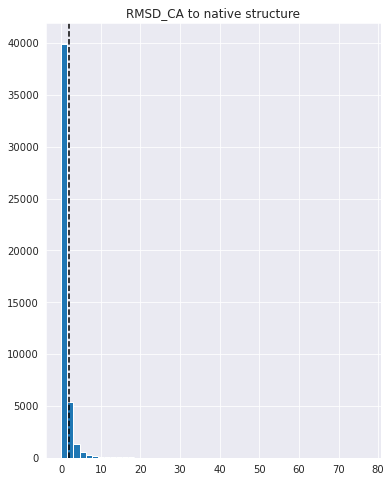

Fraction of structures with RMSD_CA < 2: 0.8854223036256921
Fraction of structures with RMSD_CA < 1: 0.7047412895974691

Number of structures with RMSD_CA < 2: 42541
Number of structures with RMSD_CA > 2: 5505

Number of structures with RMSD_CA < 3: 45195
Number of structures with RMSD_CA > 3: 2851

Number of structures with RMSD_CA < 4: 46274
Number of structures with RMSD_CA > 4: 1772

Number of structures with RMSD_CA < 5: 46846
Number of structures with RMSD_CA > 5: 1200



count    48046.000000
mean         1.119682
std          1.844088
min          0.006024
25%          0.417860
50%          0.624093
75%          1.144175
max         76.839791
Name: rmsd_ca, dtype: float64

In [7]:
df.hist(column="rmsd_ca", bins=50)
plt.title("RMSD_CA to native structure")
plt.axvline(2, color="k", linestyle="dashed");
plt.show()

print("Fraction of structures with RMSD_CA < 2:", len(df[df['rmsd_ca'] < 2]) / len(df))
print("Fraction of structures with RMSD_CA < 1:", len(df[df['rmsd_ca'] < 1]) / len(df))
print("")
print("Number of structures with RMSD_CA < 2:", len(df[df['rmsd_ca'] < 2]))
print("Number of structures with RMSD_CA > 2:", len(df[df['rmsd_ca'] > 2]))
print("")
print("Number of structures with RMSD_CA < 3:", len(df[df['rmsd_ca'] < 3]))
print("Number of structures with RMSD_CA > 3:", len(df[df['rmsd_ca'] > 3]))
print("")
print("Number of structures with RMSD_CA < 4:", len(df[df['rmsd_ca'] < 4]))
print("Number of structures with RMSD_CA > 4:", len(df[df['rmsd_ca'] > 4]))
print("")
print("Number of structures with RMSD_CA < 5:", len(df[df['rmsd_ca'] < 5]))
print("Number of structures with RMSD_CA > 5:", len(df[df['rmsd_ca'] > 5]))
print("")
df['rmsd_ca'].describe()

# Current training set

In [8]:
currently_training_proteins_structs = glob("/net/pulsar/home/koes/jok120/openfold/data/train_structs/random10k/*cif")
currently_training_proteins_structs = [p.split("/")[-1].split(".")[0] for p in currently_training_proteins_structs]
len(currently_training_proteins_structs), currently_training_proteins_structs[:5]

(10000, ['1yrd', '1bqe', '6en7', '5fx6', '1l8s'])

In [9]:
currently_training_proteins_alns = glob("/net/pulsar/home/koes/jok120/openfold/data/alignments/random10k/*")
currently_training_proteins_alns = [p.split("/")[-1].split(".")[0] for p in currently_training_proteins_alns]
len(currently_training_proteins_alns), currently_training_proteins_alns[:5]

(10000, ['5cc0_A', '5mov_A', '3ukg_A', '1myi_A', '7mu2_A'])

# Let's try to get a list of all the good scnmin proteins.
They should have:
* low rmsd (< 5)
* not be ASTRAL (since this likely won't work with alignments very well)
* have the same protein sequence as the one from the alignment I already have

### Low RMSD

In [10]:
RMSD_THRESHOLD = 5
df

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
48041,TBM#T0922,RMSD_CA,0.332220,71.790402
48042,TBM#T0947,RMSD_CA,1.744127,2865.212840
48043,TBM-hard#T0868,RMSD_CA,0.322329,268.443788
48044,TBM-hard#T0892,RMSD_CA,4.375860,2778.614653


In [11]:
df_lowrmsd = df[df['rmsd_ca'] < RMSD_THRESHOLD]
df_lowrmsd

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
48041,TBM#T0922,RMSD_CA,0.332220,71.790402
48042,TBM#T0947,RMSD_CA,1.744127,2865.212840
48043,TBM-hard#T0868,RMSD_CA,0.322329,268.443788
48044,TBM-hard#T0892,RMSD_CA,4.375860,2778.614653


In [12]:
# Look for the substring 1ZTN in the list of proteins with low RMSD_CA
df_lowrmsd[df_lowrmsd['protein_name'].str.contains("1TZN")]

,protein_name,key,rmsd_ca,duration
12496,1TZN_2_a,RMSD_CA,0.696104,1211.396756


In [5]:
# !for d in $(ls -1 /net/pulsar/home/koes/jok120/openfold/data/alignments/scnmin_alignments/ ); do mv /net/pulsar/home/koes/jok120/scnmin230306/min/$d /net/pulsar/home/koes/jok120/scnmin230306/min/$(echo $d | tr '[:lower:]' '[:upper:]'); done

In [ ]:
# Using python, look for directory names like 1tzn_a and rename directory so that the characters following the _ are capitalized
import os
for d in os.listdir("/net/pulsar/home/koes/jok120/openfold/data/alignments/scnmin_alignments/"):


### Removing ASTRAL & Improve Names

In [15]:
# Remove the rows in the dataframe that contain only one _ in the protein_name column
df_lowrmsd_nonastral = df_lowrmsd[df_lowrmsd['protein_name'].str.count("_")==2]
df_lowrmsd_nonastral

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
48025,90#3IMO_1_A,RMSD_CA,0.328261,246.541895
48027,90#4U6F_78_Q2,RMSD_CA,2.325935,563.695552
48028,9ANT_3_A,RMSD_CA,0.571385,177.162797
48029,9PAI_2_B,RMSD_CA,0.706359,54.568192


In [16]:
# Create a new column in the dataframe that contains the protein_name without the _1 or _2
df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name'].str.split("_").str[0].str.lower() + "_" + df_lowrmsd_nonastral['protein_name'].str.split("_").str[2]
# If the protein_name_std starts with a number and a #, remove the start of the name
df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name_std'].str.replace("^[0-9]+#", "")

/tmp/ipykernel_3123770/924830777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name'].str.split("_").str[0].str.lower() + "_" + df_lowrmsd_nonastral['protein_name'].str.split("_").str[2]
/tmp/ipykernel_3123770/924830777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name_std'].str.replace("^[0-9]+#", "")
/tmp/ipykernel_3123770/924830777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [17]:
df_lowrmsd_nonastral

,protein_name,key,rmsd_ca,duration,protein_name_std
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A
...,...,...,...,...,...
48025,90#3IMO_1_A,RMSD_CA,0.328261,246.541895,3imo_A
48027,90#4U6F_78_Q2,RMSD_CA,2.325935,563.695552,4u6f_Q2
48028,9ANT_3_A,RMSD_CA,0.571385,177.162797,9ant_A
48029,9PAI_2_B,RMSD_CA,0.706359,54.568192,9pai_B


### Looking more closely at sequences
Can we find proteins of mine that exactly match the RODA MSAs I already have? Those would
be the easiest to work with.

In [18]:
def get_sequence(pdbfile):
    """Returns the sequence of the protein in the pdbfile."""
    pdb = pr.parsePDB(pdbfile)
    return pdb.ca.getSequence()

get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/2FD3_1_A.pdb")

'SDKIIHLTDDSFDTDVLKADGAILVDFWAEWCGHCKMIAPILDEIADEYQGKLTVAKLNIDQNPGTAPKYGIRGIPTLLLFKNGEVAATKVGALSKGQLKEFLDANLA'

In [19]:
df_lowrmsd_nonastral.progress_apply?

Signature: df_lowrmsd_nonastral.progress_apply(func, *args, **kwargs)
Docstring:
Parameters
----------
df  : (DataFrame|Series)[GroupBy]
    Data (may be grouped).
func  : function
    To be applied on the (grouped) data.
**kwargs  : optional
    Transmitted to `df.apply()`.
File:      ~/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/tqdm/std.py
Type:      method


In [21]:
# Add sequence column to dataframe using get_sequence function
df_lowrmsd_nonastral['sequence'] = df_lowrmsd_nonastral['protein_name'].progress_apply(lambda x: get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/" + x + ".pdb"))
# Save intermediate dataframe
df_lowrmsd_nonastral.to_csv("df_lowrmsd_nonastral.csv")

  0%|          | 0/32994 [00:00<?, ?it/s]

/tmp/ipykernel_3123770/272017693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['sequence'] = df_lowrmsd_nonastral['protein_name'].progress_apply(lambda x: get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/" + x + ".pdb"))


In [13]:
df_lowrmsd_nonastral = pd.read_csv("df_lowrmsd_nonastral.csv")

In [14]:
# Let's add a column representing the query sequence
def get_query_sequence(protein_name):
    try:
        alignment_file = glob(f"/net/pulsar/home/koes/jok120/openfold/data/alignments/roda_flattened/alignments/{protein_name}/*.a3m")[0]
    except IndexError:
        return None
    # Read the second line of the alignment file, which contains the query sequence
    with open(alignment_file, "r") as f:
        query_sequence = f.readlines()[1].strip()
    return query_sequence

df_lowrmsd_nonastral['query_sequence'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: get_query_sequence(x))

  0%|          | 0/32994 [00:00<?, ?it/s]

In [15]:
# Lets denote if we even have an existing cif file
def cif_exists(protein_name):
    """Returns True iff the cif file exists."""
    return os.path.exists(f"/net/pulsar/home/koes/jok120/openfold/data/train_structs/roda_pdbs_snapshotted_flattened_do_not_overwrite/{protein_name.split('_')[0]}.cif")

df_lowrmsd_nonastral['cif_exists'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: cif_exists(x))

  0%|          | 0/32994 [00:00<?, ?it/s]

In [16]:
POOR_ALIGNMENT_FILE = open("seqs_didnot_match2.txt", "w")    
def query_and_sequence_match(protein_name, query_sequence, protein_sequence):
    """Returns True iff the query sequence matches the sequence."""
    if query_sequence != protein_sequence:
        POOR_ALIGNMENT_FILE.write(f"{protein_name},{protein_sequence},{query_sequence}\n")
        return False
    else:
        return True

In [17]:
# Add a column that denotes if the string fields query_sequence and sequence are equal
df_lowrmsd_nonastral['sequence_matches_query'] = df_lowrmsd_nonastral.apply(lambda x: query_and_sequence_match(x['protein_name_std'], x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral


,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
2,2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False
3,3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
...,...,...,...,...,...,...,...,...,...,...
32989,48025,90#3IMO_1_A,RMSD_CA,0.328261,246.541895,3imo_A,HMALTVKDVNILSQYISGVMARADHHAGNVEEIALALAGAILWRKD...,MGSSHHHHHHSSGLVPRGSHMALTVKDVNILSQYISGVMARADHHA...,True,False
32990,48027,90#4U6F_78_Q2,RMSD_CA,2.325935,563.695552,4u6f_Q2,VNVPKTRKTYCKGKTCRKHTQHKVTQYKAGKASLFAQGKRRYDRKQ...,None,True,False
32991,48028,9ANT_3_A,RMSD_CA,0.571385,177.162797,9ant_A,RQTYTRYQTLELEKEFHFNRYLTRRRRIEIAHALSLTERQIKIWFQ...,MERKRGRQTYTRYQTLELEKEFHFNRYLTRRRRIEIAHALSLTERQ...,True,False
32992,48029,9PAI_2_B,RMSD_CA,0.706359,54.568192,9pai_B,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,True,True


In [18]:
df_lowrmsd_nonastral[df_lowrmsd_nonastral['sequence_matches_query'] == True]

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
3,3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
6,6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True
...,...,...,...,...,...,...,...,...,...,...
32981,48016,8PRN_1_A,RMSD_CA,0.411220,1757.876707,8prn_A,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,True,True
32987,48023,90#2K2I_2_B,RMSD_CA,0.309103,26.731250,2k2i_B,RADLHHQHSVLHRALQAWVT,RADLHHQHSVLHRALQAWVT,True,True
32988,48024,90#2LEM_1_A,RMSD_CA,2.168527,1046.258272,2lem_A,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,True,True
32992,48029,9PAI_2_B,RMSD_CA,0.706359,54.568192,9pai_B,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,True,True


In [19]:
# Show rows where the alignment exists and matches and the cif file exists
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_matches_query'] == True) & (df_lowrmsd_nonastral['cif_exists'] == True)]

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
3,3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
6,6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True
...,...,...,...,...,...,...,...,...,...,...
32981,48016,8PRN_1_A,RMSD_CA,0.411220,1757.876707,8prn_A,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,True,True
32987,48023,90#2K2I_2_B,RMSD_CA,0.309103,26.731250,2k2i_B,RADLHHQHSVLHRALQAWVT,RADLHHQHSVLHRALQAWVT,True,True
32988,48024,90#2LEM_1_A,RMSD_CA,2.168527,1046.258272,2lem_A,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,True,True
32992,48029,9PAI_2_B,RMSD_CA,0.706359,54.568192,9pai_B,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,True,True


In [20]:
# Add a column that denotes if the sequence is a subset of the query sequence
def sequence_is_subsequence(query_sequence, protein_sequence):
    """Returns True iff the protein sequence is a subset of the query sequence."""
    if query_sequence is not None and protein_sequence in query_sequence:
        return True
    else:
        return False

df_lowrmsd_nonastral['sequence_is_subsequence'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_is_subsequence(x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False)]

  0%|          | 0/32994 [00:00<?, ?it/s]

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence
2,2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False,True
5,5,10#3NO7_1_A,RMSD_CA,1.095250,81.944621,3no7_A,VKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAAALDAEVQRL...,GPEASARSEVKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAA...,True,False,True
7,7,10#2FK5_1_A,RMSD_CA,0.852786,1856.631196,2fk5_A,RARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQKA...,MRARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQK...,True,False,True
10,10,10#3ALR_1_A,RMSD_CA,0.329806,65.406627,3alr_A,FCSFCKHNGETEAVYTSHYLKNRDGDVMCPYLRQYKCPLCGATGAK...,GPLGSESPSGPIRSRDSPEQNTSPGGGKPKSSPAERKFCSFCKHNG...,True,False,True
11,11,10#4QTQ_1_A,RMSD_CA,0.394599,1130.503295,4qtq_A,KMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIMLCNRSP...,MQKDLKMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIML...,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
32984,48020,90#1CF7_4_B,RMSD_CA,0.630328,418.163980,1cf7_B,GKGLRHFSMKVCEKVQRKGTTSYNEVADELVSEFTNSNNHLAADSA...,RSKKGDKNGKGLRHFSMKVCEKVQRKGTTSYNEVADELVSEFTNSN...,True,False,True
32985,48021,90#1ZZW_1_A,RMSD_CA,0.360114,1203.802816,1zzw_A,MAELTPILPFLFLGNEQDAQDLDTMQRLNIGYVINVTTHLPLYHYE...,MAELTPILPFLFLGNEQDAQDLDTMQRLNIGYVINVTTHLPLYHYE...,True,False,True
32986,48022,90#2D1P_1_A,RMSD_CA,0.359684,456.398617,2d1p_A,GSMRFAIVVTGPAYGTQQASSAFQFAQALIADGHELSSVFFYREGV...,MRGSHHHHHHGSMRFAIVVTGPAYGTQQASSAFQFAQALIADGHEL...,True,False,True
32989,48025,90#3IMO_1_A,RMSD_CA,0.328261,246.541895,3imo_A,HMALTVKDVNILSQYISGVMARADHHAGNVEEIALALAGAILWRKD...,MGSSHHHHHHSSGLVPRGSHMALTVKDVNILSQYISGVMARADHHA...,True,False,True


In [21]:
# Add a column that denotes the length by which the sequence and query sequence differ
def sequence_length_difference(query_sequence, protein_sequence):
    """Returns the length difference between the query sequence and the protein sequence."""
    if query_sequence is not None:
        return len(query_sequence) - len(protein_sequence)
    else:
        return None
    
df_lowrmsd_nonastral['len_difference'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_length_difference(x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False)]

  0%|          | 0/32994 [00:00<?, ?it/s]

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
2,2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False,True,19.0
5,5,10#3NO7_1_A,RMSD_CA,1.095250,81.944621,3no7_A,VKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAAALDAEVQRL...,GPEASARSEVKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAA...,True,False,True,20.0
7,7,10#2FK5_1_A,RMSD_CA,0.852786,1856.631196,2fk5_A,RARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQKA...,MRARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQK...,True,False,True,5.0
10,10,10#3ALR_1_A,RMSD_CA,0.329806,65.406627,3alr_A,FCSFCKHNGETEAVYTSHYLKNRDGDVMCPYLRQYKCPLCGATGAK...,GPLGSESPSGPIRSRDSPEQNTSPGGGKPKSSPAERKFCSFCKHNG...,True,False,True,43.0
11,11,10#4QTQ_1_A,RMSD_CA,0.394599,1130.503295,4qtq_A,KMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIMLCNRSP...,MQKDLKMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIML...,True,False,True,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32984,48020,90#1CF7_4_B,RMSD_CA,0.630328,418.163980,1cf7_B,GKGLRHFSMKVCEKVQRKGTTSYNEVADELVSEFTNSNNHLAADSA...,RSKKGDKNGKGLRHFSMKVCEKVQRKGTTSYNEVADELVSEFTNSN...,True,False,True,13.0
32985,48021,90#1ZZW_1_A,RMSD_CA,0.360114,1203.802816,1zzw_A,MAELTPILPFLFLGNEQDAQDLDTMQRLNIGYVINVTTHLPLYHYE...,MAELTPILPFLFLGNEQDAQDLDTMQRLNIGYVINVTTHLPLYHYE...,True,False,True,2.0
32986,48022,90#2D1P_1_A,RMSD_CA,0.359684,456.398617,2d1p_A,GSMRFAIVVTGPAYGTQQASSAFQFAQALIADGHELSSVFFYREGV...,MRGSHHHHHHGSMRFAIVVTGPAYGTQQASSAFQFAQALIADGHEL...,True,False,True,10.0
32989,48025,90#3IMO_1_A,RMSD_CA,0.328261,246.541895,3imo_A,HMALTVKDVNILSQYISGVMARADHHAGNVEEIALALAGAILWRKD...,MGSSHHHHHHSSGLVPRGSHMALTVKDVNILSQYISGVMARADHHA...,True,False,True,19.0


In [22]:
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False) & (df_lowrmsd_nonastral['len_difference'] == 1)]

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
98,109,1A05_1_A,RMSD_CA,0.597188,8337.683995,1a05_A,MKKIAIFAGDGIGPEIVAAARQVLDAVDQAAHLGLRCTEGLVGGAA...,MKKIAIFAGDGIGPEIVAAARQVLDAVDQAAHLGLRCTEGLVGGAA...,True,False,True,1.0
101,114,1A0K_1_A,RMSD_CA,0.284711,363.612162,1a0k_A,SWQSYVDDHLMCDVEGNHLTAAAILGQDGSVWAQSAKFPQLKPQEI...,MSWQSYVDDHLMCDVEGNHLTAAAILGQDGSVWAQSAKFPQLKPQE...,True,False,True,1.0
104,117,1A0R_1_B,RMSD_CA,1.109902,4517.526881,1a0r_B,SELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRT...,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,True,False,True,1.0
116,138,1A1S_1_A,RMSD_CA,0.684303,9682.760599,1a1s_A,VVSLAGRDLLCLQDYTAEEIWTILETAKMFKIWQKIGKPHRLLEGK...,VVSLAGRDLLCLQDYTAEEIWTILETAKMFKIWQKIGKPHRLLEGK...,True,False,True,1.0
127,155,1A2X_1_A,RMSD_CA,2.305642,1065.897233,1a2x_A,DQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRMLG...,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,True,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32938,47949,6FIV_1_A,RMSD_CA,0.716526,321.202096,6fiv_A,GTTTTLEKRPEILIFVNGYPIKFLLDTGADITILNRRDFQVKNSIE...,VGTTTTLEKRPEILIFVNGYPIKFLLDTGADITILNRRDFQVKNSI...,True,False,True,1.0
32948,47969,6RLX_1_A,RMSD_CA,0.412103,404.688855,6rlx_A,LYSALANKCCHVGCTKRSLARFC,ELYSALANKCCHVGCTKRSLARFC,True,False,True,1.0
32949,47970,6RLX_2_B,RMSD_CA,0.302765,30.409096,6rlx_B,SWMEEVIKLCGRELVRAQIAICGMSTW,SWMEEVIKLCGRELVRAQIAICGMSTWS,True,False,True,1.0
32950,47971,6RXN_1_A,RMSD_CA,0.147873,25.445342,6rxn_A,MQKYVCNVCGYEYDPAEHDNVPFDQLPDDWCCPVCGVSKDQFSPA,XMQKYVCNVCGYEYDPAEHDNVPFDQLPDDWCCPVCGVSKDQFSPA,True,False,True,1.0


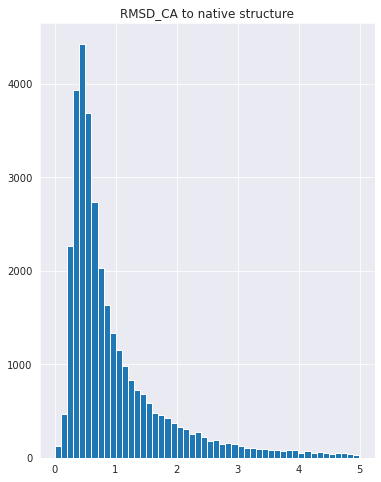

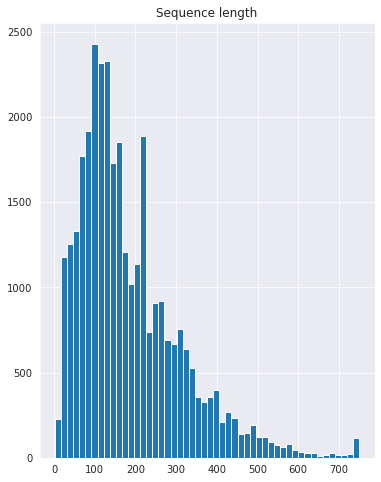

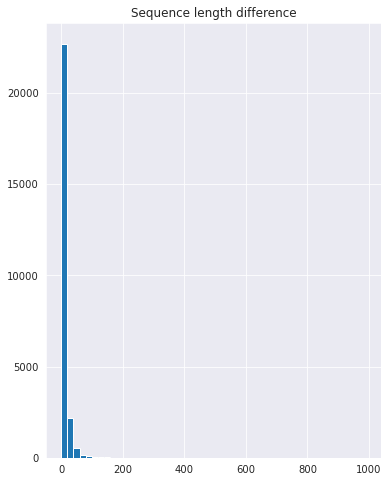

In [23]:
# Plot a histogram of the rmsd_ca values of the filtered dataframe
df_lowrmsd_nonastral.hist(column="rmsd_ca", bins=50)
plt.title("RMSD_CA to native structure")
# Make a second separate plot that doesn't overwrite the first. It should be a histogram of the sequence length
plt.figure()
df_lowrmsd_nonastral['sequence'].str.len().hist(bins=50)
plt.title("Sequence length");
# Plot a histogram of the sequence length difference
plt.figure()
df_lowrmsd_nonastral['len_difference'].hist(bins=50)
plt.title("Sequence length difference");

# Now we have a dataframe of proteins that should work without any further filtering
March 15, 10PM: 5964 proteins

In [24]:
df_filtered = df_lowrmsd_nonastral[df_lowrmsd_nonastral['sequence_matches_query']]
df_filtered

,Unnamed: 0,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
0,0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True,True,0.0
1,1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True,True,0.0
3,3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True,True,0.0
4,4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True,True,0.0
6,6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32981,48016,8PRN_1_A,RMSD_CA,0.411220,1757.876707,8prn_A,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,MISLNGYGRFGLQYVEDRGVGLEDTIISSRLRINIVGTTETDQGVT...,True,True,True,0.0
32987,48023,90#2K2I_2_B,RMSD_CA,0.309103,26.731250,2k2i_B,RADLHHQHSVLHRALQAWVT,RADLHHQHSVLHRALQAWVT,True,True,True,0.0
32988,48024,90#2LEM_1_A,RMSD_CA,2.168527,1046.258272,2lem_A,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,DEPQSQWDKVKDFANVYVDAVKDSGRDYVSQFESSSLGQQLNLNLL...,True,True,True,0.0
32992,48029,9PAI_2_B,RMSD_CA,0.706359,54.568192,9pai_B,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,True,True,True,0.0


In [25]:
df_filtered.to_csv("df_filtered.csv")

# Fill up the correct data dirs with the selected scnmin proteins

In [ ]:
alignment_target_dir = "/net/pulsar/home/koes/jok120/openfold/data/alignments/scnmin_alignments0510/"
alignment_source_dir = "/net/pulsar/home/koes/jok120/openfold/data/alignments/roda_flattened/alignments/"

# Create symlinks to the alignments in the scnmin_alignments directory
for protein_name in tqdm(df_filtered['protein_name_std']):
    !ln -s {alignment_source_dir}/{protein_name} {alignment_target_dir}/{protein_name}

In [ ]:
# Parallelize the above for loop
from multiprocessing import Pool
from tqdm import tqdm

def create_symlink(protein_name):
    !ln -s {alignment_source_dir}/{protein_name} {alignment_target_dir}/{protein_name}

# Create symlinks to the alignments in the scnmin_alignments directory, using tqdm and imap
with Pool(64) as p:
    for _ in tqdm(p.imap(create_symlink, df_filtered['protein_name_std']), 
                  total=len(df_filtered['protein_name_std'])):
        pass

    

In [31]:
structure_source_dir = "/net/pulsar/home/koes/jok120/scnmin230306/min/"
structure_target_dir = "/net/pulsar/home/koes/jok120/openfold/data/train_structs/scnmin_structs0510/"

def create_structure_symlink(protein_name_protein_name_std):
    protein_name, protein_name_std = protein_name_protein_name_std
    !ln -s {structure_source_dir}/{protein_name}.pdb {structure_target_dir}/{protein_name_std}.pdb

# Create symlinks to the structures in the scnmin_structs directory, using tqdm and imap
with Pool(64) as p:
    for _ in tqdm(p.imap(create_structure_symlink,zip( df_filtered['protein_name'], df_filtered['protein_name_std'])), 
                  total=len(df_filtered['protein_name_std'])):
        pass

# Create symlinks to the structures in the scnmin_structs directory
# for protein_name, protein_name_std in zip(df_filtered['protein_name'], df_filtered['protein_name_std']):
#     !ln -s {structure_source_dir}/{protein_name}.pdb {structure_target_dir}/{protein_name_std}.pdb

100%|██████████| 11687/11687 [01:11<00:00, 164.13it/s]


Not shown: Copy the entire roda_snapshotted structure directory to use as templates.

In [ ]:
# Save the filtered datafrom
df_filtered.to_csv("lowrmsd_filtered.csv", index=False)

In [77]:
# Now we want to do the same thing but convert the structures to cif files
from Bio.PDB import PDBParser, MMCIFIO
input_files = glob("/net/pulsar/home/koes/jok120/openfold/data/train_structs/scnmin_structs/*.pdb")
output_files = [f.replace(".pdb", ".cif").replace("train_structs", "template_structs").replace("scnmin_structs", "scnmin_structs_cif") for f in input_files]
for input_file, output_file in tqdm(zip(input_files, output_files)):
    p = PDBParser()
    struc = p.get_structure("", input_file)
    io = MMCIFIO()
    io.set_structure(struc)
    io.save(output_file)

0it [00:00, ?it/s]

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1886
  warnings.warn(
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2493
  warnings.warn(
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1926
  warnings.warn(
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1674
  warnings.warn(
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2472
  warni

In [ ]:
#rsync -hvrPtL scnmin_alignments/ h2p:/zfs1/dkoes/jok120/openfold/data/alignments/
#rsync -hvrPtL scnmin_structs/ h2p:/zfs1/dkoes/jok120/openfold/data/train_structs/


# Notes

In [ ]:
# TODO: See how hard it is to splice alignments by 1 or so. If it's not too hard, do it. If it is, just use the full alignment.

# Load and splice alignments according to how different the query and sequence are
def splice_alignment(protein_name, query_sequence, protein_sequence):
    """Returns the spliced alignment."""
    try:
        alignment_file = glob(f"/net/pulsar/home/koes/jok120/openfold/data/alignments/roda_flattened/alignments/{protein_name}/*.a3m")[0]
    except IndexError:
        return None
    # Read the alignment file
    with open(alignment_file, "r") as f:
        alignment = f.readlines()
    # Find the index of the query sequence
    query_index = alignment.index(f">{query_sequence}
                                  
    # Find the index of the protein sequence
    protein_index = alignment.index(f">{protein_sequence}
                                    
    # Splice the alignment
    spliced_alignment = alignment[query_index:protein_index+1]
    return spliced_alignment